In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import mlgrad.model as model
import mlgrad.func as func
# import mlgrad.regular as regular
import mlgrad.avragg as avragg
import mlgrad.loss as loss
import mlgrad.regr as regr

import sys
print(sys.version)

3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', index_col='id')
df

,log.Te,log.light
id,,
1,4.37,5.23
2,4.56,5.74
3,4.26,4.93
4,4.56,5.74
5,4.30,5.19
6,4.46,5.46
7,3.84,4.65
8,4.57,5.27
9,4.26,5.57


In [3]:
X = log_Te = df["log.Te"].values
Y = log_light = df["log.light"].values
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
N = len(X)
print((N-7)/N)

0.851063829787234


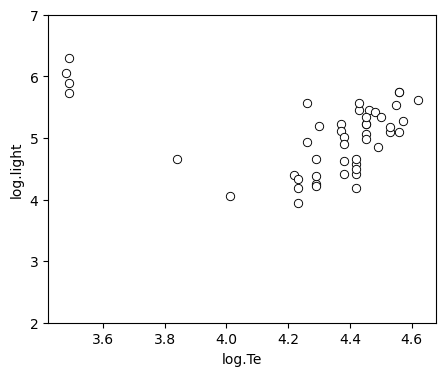

In [4]:
plt.figure(figsize=(5,4))
plt.scatter(log_Te, log_light, s=36, c='w', edgecolors='k', linewidth=0.66)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.ylim(2, 7)
plt.show()

In [5]:
mod_ls = model.LinearModel(1)
mod_ls.init_param()
mod_r = model.LinearModel(1)
mod_r.init_param()
mod_m = model.LinearModel(1)
mod_m.init_param()
mod_wm = model.LinearModel(1)
mod_wm.init_param()
# mod_wmr = model.LinearModel(1)
# mod_wmr.init_param()
mod_wmm = model.LinearModel(1)
mod_wmm.init_param()
mod_ls2 = model.LinearModel(1)
mod_ls2.init_param()

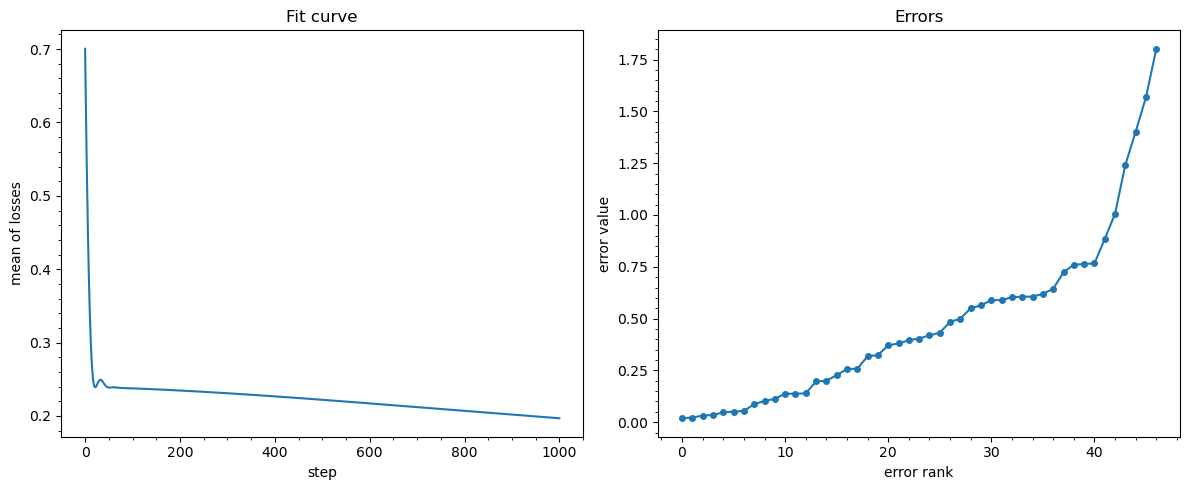

In [6]:
regr_ls = regr.regression(log_Te[:,None], log_light, mod_ls, 
                          h=0.01, n_iter=1000)
regr.plot_losses_and_errors(regr_ls, log_Te[:,None], log_light, logscale=False)

0.24244218817617014


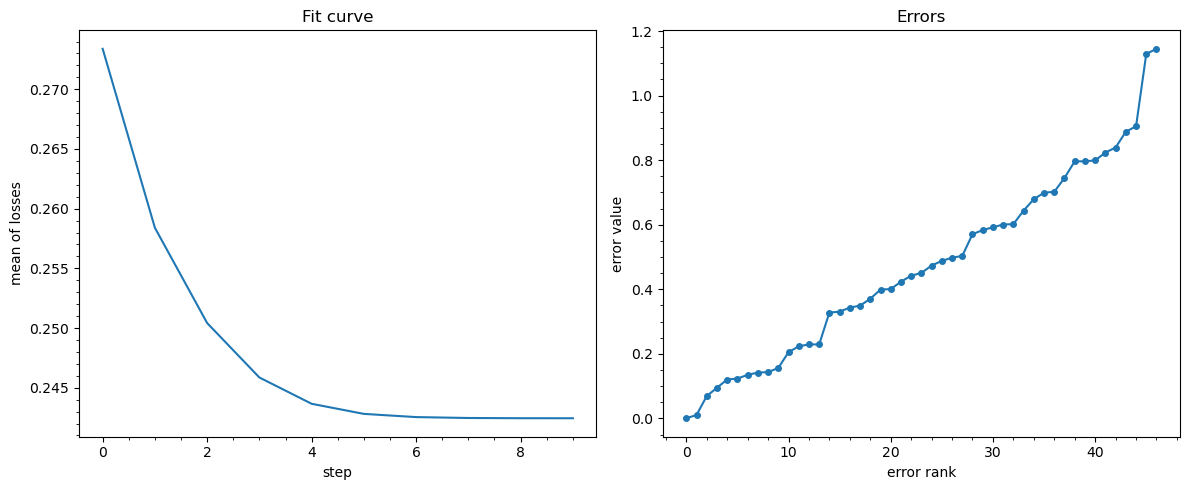

In [7]:
regr_r = regr.r_regression_irls(log_Te[:,None], log_light, mod_r, 
                                func.LogSquare(), h=0.01, n_iter=1000)
regr.plot_losses_and_errors(regr_r, log_Te[:,None], log_light, logscale=False)

0.04427199051693946


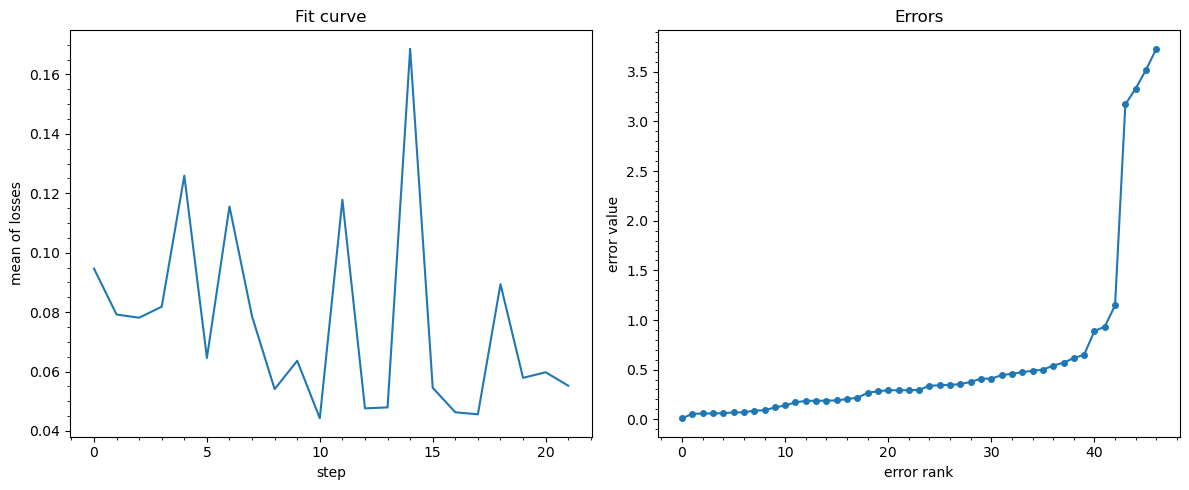

[-6.866  2.700]


In [8]:
avrfunc_m = regr.averaging_function("M", func.quantile_func(0.5, func.Sqrt(0.001)))
regr_m = regr.m_regression_irls(log_Te[:,None], log_light, mod_m, 
                                agg_func=avrfunc_m, h=0.01, n_iter=1000)
regr.plot_losses_and_errors(regr_m, log_Te[:,None], log_light, logscale=False)
print(np.asarray(mod_m.param))

0.07356898003183304


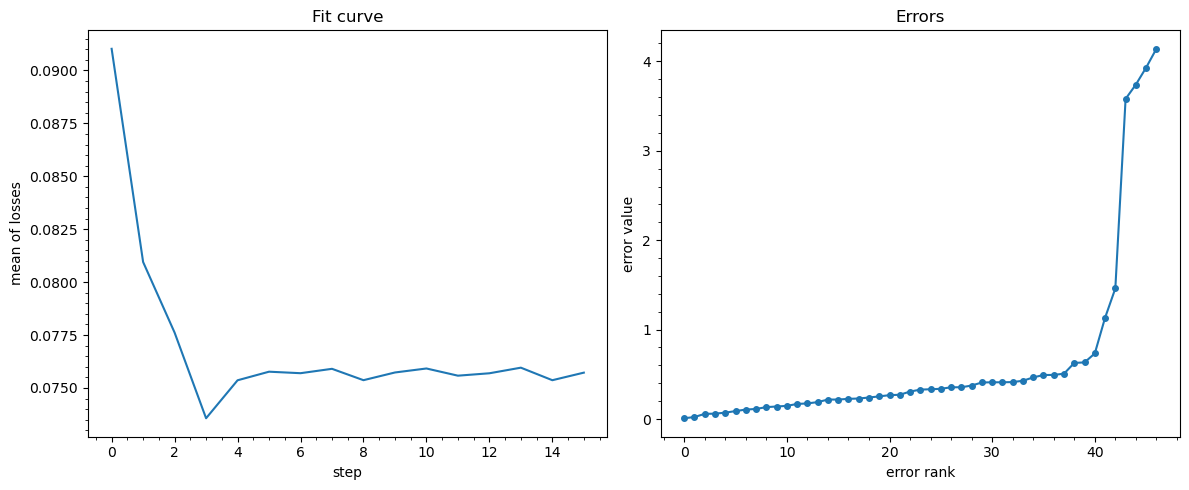

[-8.219  2.971]


In [9]:
avrfunc_wm = regr.averaging_function("WM", func.quantile_func(0.85, func.Sqrt(0.001)))
regr_wm = regr.m_regression_irls(log_Te[:,None], log_light, mod_wm, 
                                 agg_func=avrfunc_wm, h=0.01, n_iter=1000)
regr.plot_losses_and_errors(regr_wm, log_Te[:,None], log_light, logscale=False)
print(np.asarray(mod_wm.param))

In [10]:
# avrfunc_s = regr.scaling_function("S", func.Sqrt(0.001))
# regr_ms = regr.m_regression_irls(log_Te[:,None], log_light, mod_m, 
#                                 agg_func=avrfunc_s, h=0.001, n_iter=1000)
# regr.plot_losses_and_errors(regr_ms, log_Te[:,None], log_light, logscale=False)
# print(avrfunc_s.u)

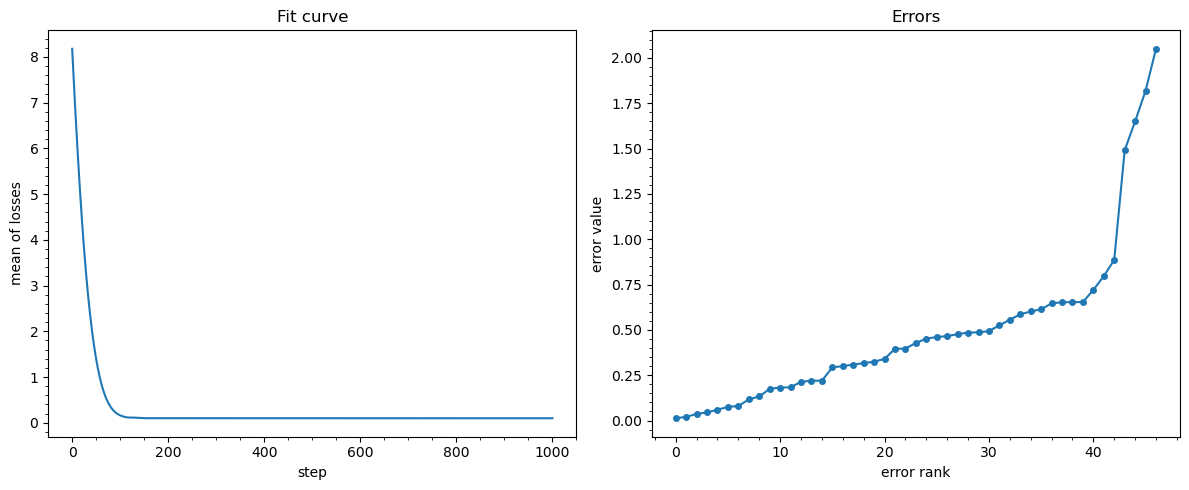

[1.476 0.792]


In [11]:
avrfunc_wmm = regr.averaging_function("WM", func.quantile_func(0.85, func.Sqrt(0.001)))
regr_wmm = regr.m_regression(log_Te[:,None], log_light, mod_wmm, 
                                 agg_func=avrfunc_wmm, h=0.01, n_iter=1000)
regr.plot_losses_and_errors(regr_wmm, log_Te[:,None], log_light, logscale=False)
print(np.asarray(mod_wmm.param))

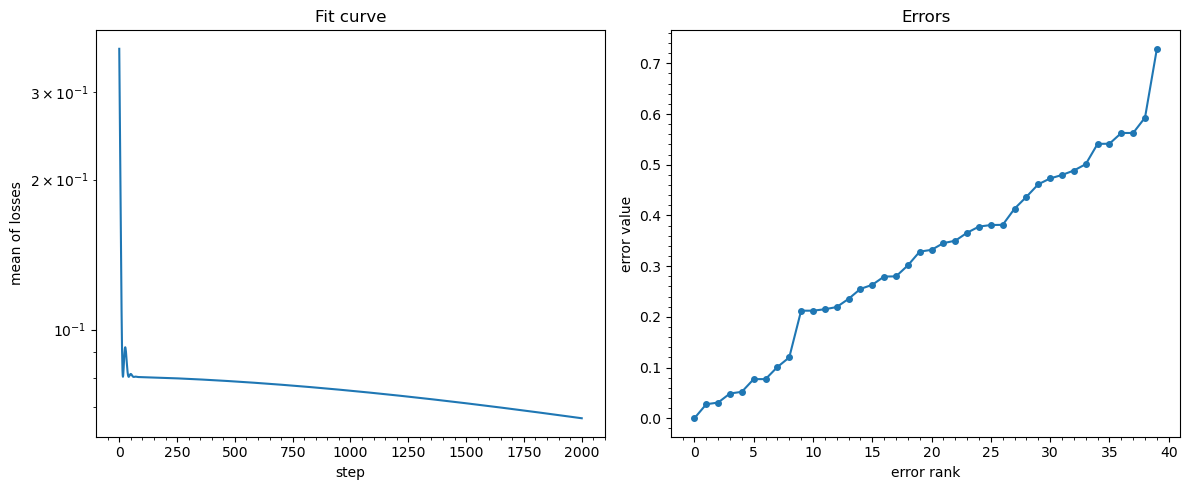

In [12]:
X_wo, Y_wo = regr.exclude_outliers(mod_wm, log_Te, log_light, 7)
regr_ls2 = regr.regression(X_wo[:,None], Y_wo, mod_ls2, h=0.01, n_iter=2000)
regr.plot_losses_and_errors(regr_ls2, X_wo[:,None], Y_wo)

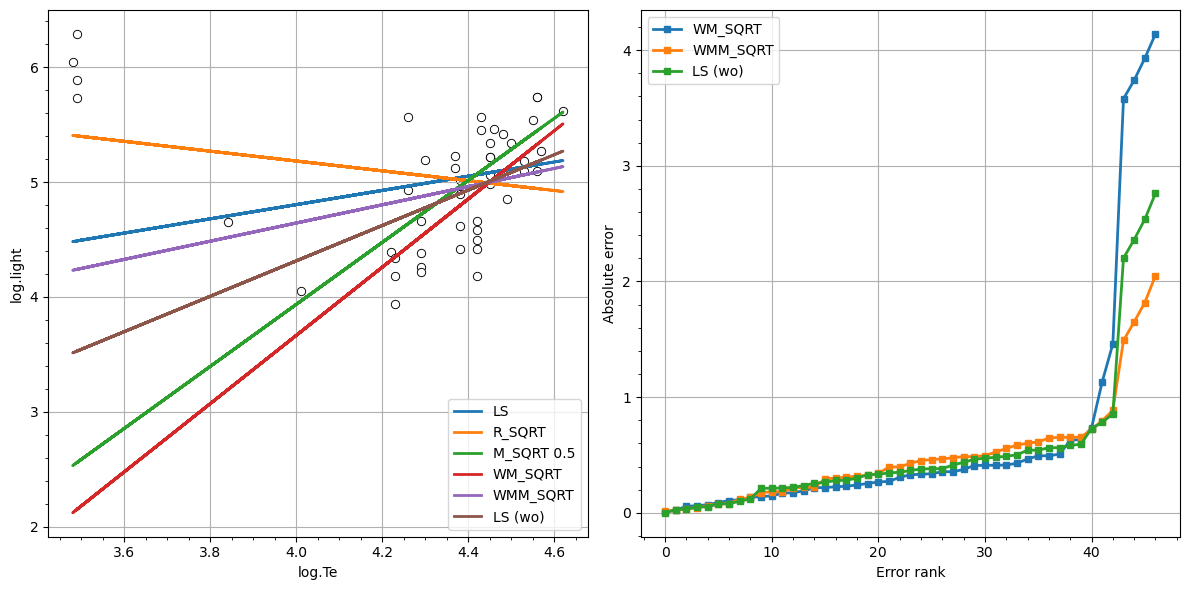

In [13]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter(log_Te, log_light, s=36, c='w', edgecolors='k', linewidth=0.66)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.plot(X[:,None], mod_ls.evaluate_all(X[:,None]), label='LS', linewidth=2.)
plt.plot(X[:,None], mod_r.evaluate_all(X[:,None]), label='R_SQRT', linewidth=2.)
plt.plot(X[:,None], mod_m.evaluate_all(X[:,None]), label='M_SQRT 0.5', linewidth=2.)
plt.plot(X[:,None], mod_wm.evaluate_all(X[:,None]), label='WM_SQRT', linewidth=2.)
# plt.plot(X[:,None], mod_wmr.evaluate_all(X[:,None]), label='WMR_SQRT', linewidth=2.)
plt.plot(X[:,None], mod_wmm.evaluate_all(X[:,None]), label='WMM_SQRT', linewidth=2.)
plt.plot(X[:,None], mod_ls2.evaluate_all(X[:,None]), label='LS (wo)', linewidth=2.)
plt.legend()
plt.minorticks_on()
plt.grid(1)
plt.subplot(1,2,2)
# plt.plot(sorted(np.abs(Y-mod_ls.evaluate_all(X[:,None]))), label='LS', linewidth=2., marker='s', markersize=4)
# plt.plot(sorted(np.abs(Y-mod_r.evaluate_all(X[:,None]))), label='R_SQRT', linewidth=2., marker='s', markersize=4)
# plt.plot(sorted(np.abs(Y-mod_m.evaluate_all(X[:,None]))), label='M_SQRT 0.5', linewidth=2., marker='s', markersize=4)
plt.plot(sorted(np.abs(Y-mod_wm.evaluate_all(X[:,None]))), label='WM_SQRT', linewidth=2., marker='s', markersize=4)
plt.plot(sorted(np.abs(Y-mod_wmm.evaluate_all(X[:,None]))), label='WMM_SQRT', linewidth=2., marker='s', markersize=4)
plt.plot(sorted(np.abs(Y-mod_ls2.evaluate_all(X[:,None]))), label='LS (wo)', linewidth=2., marker='s', markersize=4)
plt.legend()
plt.minorticks_on()
plt.xlabel('Error rank')
plt.ylabel('Absolute error')
plt.grid(1)
plt.tight_layout()
plt.show()